## Objectif du TD N°1 interpretable Machine Learning


Ce td vise à interpréter les modèles de machine learning que vous avez crées lors du TD N°2 SVM.

Vous chercherez à interpréter globalement votre modèle avec les méthodes vues en cours et surtout examiner la différence entre des modèles linéaires et non linéaires.


## Enoncé du TD

### Importer le modèle du TD N°2

1. Importer le jeu de données breast cancer disponible dans le module sklearn.datasets
2. Importer un modèle non linéaire utilisé lors du TD N°2 ou alors recréer l'ensemble de la pipeline visant à le générer
3. Vérifier que votre modèle réalise correctement une prédiction pour un individu


### Comparer interprétation des coéfficients et méthode globale

4. Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats
5. Utiliser maintenant les différentes méthodes d'interprétation de modèle avec les résultats de le résultats des coefficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 
6. Commenter

### Interpréter un modèle non linéaire

7. Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales
8. Commenter la différence de résultat






In [34]:
def winsorize_data(xtrain, xtest, feature):

    """_summary_

    Fonction permettant de winsorizez un jeu d'entrainement et de test en calculant
    les quantiles sur le jeu d'entrainement et l'appliquant sur le jeu test.

    Pour se prémunir d'un data leak.
    
    """
    
    # Définir les quantiles sur xtrain
    lower_quantile = 0.05  # 5% quantile
    upper_quantile = 0.95  # 95% quantile

    # Calcul des bornes à partir des quantiles sur xtrain
    lower_bound = np.quantile(xtrain[feature], lower_quantile)
    upper_bound = np.quantile(xtrain[feature], upper_quantile)

    # Appliquer la winsorisation sur xtrain
    xtrain_winsorized = np.clip(xtrain[feature], lower_bound, upper_bound)

    # Appliquer les mêmes bornes sur xtest
    xtest_winsorized = np.clip(xtest[feature], lower_bound, upper_bound)

    return(xtrain_winsorized, xtest_winsorized)

In [35]:
def data_prep_brest_cancer(df, features_name):
    #Calculate correlation
    m_corr = df[features_name].corr(method="spearman")
    #Symetrique on conserve la partie sup
    upper_tri = m_corr.where(np.triu(np.ones(m_corr.shape),k=1).astype(np.bool))
    
    #Suppresion des colonnes avec corrélation supérieur à 0.85
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
    
    #Drop des colonnes trop corrélées
    df_no_corr = df.drop(to_drop, axis=1)
    training_features = df_no_corr.columns[:-1]

    ############
    # RESAMPLE #
    ############

    #Stratégie de undersampling. On peut aussi Upsample
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(df_no_corr.iloc[:,:-1], df_no_corr.target)

    #Train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    #Step winsorize skew distribution 
    #Winsorize outliers
    for col in X_train.columns:
         
        X_train[col], X_test[col] = winsorize_data(xtrain= X_train, xtest= X_test, feature=col)

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)

    

    return(X_train_sc, X_test_sc, y_train, y_test, training_features, scaler)

## Partie Code

#### 1)Importer le jeu de données breast cancer disponible dans le module sklearn.datasets

In [36]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import pickle

In [37]:
#Load dataset breast cancer
data = load_breast_cancer()

breast = pd.DataFrame(data = np.c_[data.data,data.target], columns=list(data.feature_names)+['target'] )
#Nom des colonnes et remplacer les espaces par un "_"
features_name = [name.replace(" ", "_") for name in data.feature_names]
breast.columns= features_name+['target']

print("Aperçu des premières lignes :")
print(breast.head())
print("\nDimensions du DataFrame :")
print(breast.shape)
print("\nInformation sur les colonnes et types de données :")
print(breast.info())
print("\nValeurs manquantes :")
print(breast.isnull().sum())

Aperçu des premières lignes :
   mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean_compactness  mean_concavity  mean_concave_points  mean_symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean_fractal_dimension  ...  worst_texture  worst_perimeter

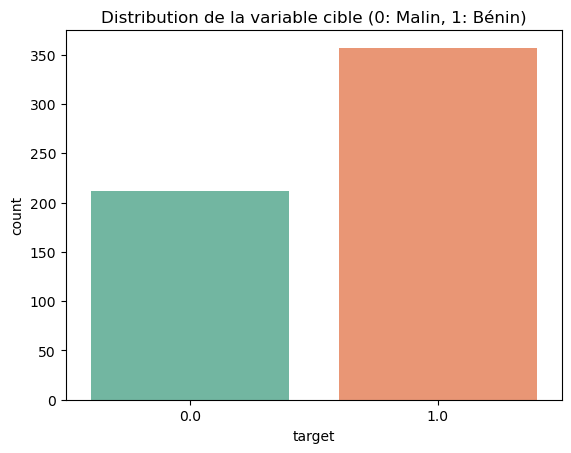

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisation de la distribution de la variable cible
sns.countplot(x='target', data=breast, palette='Set2')
plt.title("Distribution de la variable cible (0: Malin, 1: Bénin)")
plt.show()


Commentaires jeu de données : 

- 569*31
- variables epxlicatives de type float
- absence de NA

On inverse les modalités de Y car on cherche à déterminer s'il s'agit d'un cancer

Actuellement :

y= 0 maligne
y =1 bénin

In [39]:
# On inverse la modalité de référence
breast.target = 1- breast.target

Notre objectif est de déterminer si une tumeur est maligne ou bénigne. Pour cela, il est nécessaire d'inverser les modalités de la variable cible, de manière à ce que 1 représente un cancer malin et 0 un cancer bénin.

#### 2) Recréer l'ensemble de la pipeline visant à générer un SVM non linéaire (RBF ou degree >1)


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# Préparation de la data
X = breast.drop(columns=['target'])  
y = breast['target'] 

X_train_sc, X_test_sc, y_train, y_test, training_features, scaler = data_prep_brest_cancer(df=breast, features_name=features_name)

best_model = SVC(random_state=77, C=0.5, kernel='poly',degree=2)

best_model.fit(X_train_sc, y_train)

/var/folders/q_/bwqh9gpd2r5fc6bhl_ft6hb40000gn/T/ipykernel_81372/1915541627.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = m_corr.where(np.triu(np.ones(m_corr.shape),k=1).astype(np.bool))


SVC(C=0.5, degree=2, kernel='poly', random_state=77)

#### 3) Vérifier que votre modèle réalise correctement une prédiction pour un individu

In [43]:
#Prédiction pour un individu
best_model.predict(X_test_sc[0].reshape(1,16))

print("Prédiction : ", best_model.predict(X_test_sc[0].reshape(1,16)))
print("Réelle : ", y_test.iloc[0])


Prédiction :  [0.]
Réelle :  0.0


La prédiction du modèle (0.) correspond à la vérité terrain (0.0), ce qui signifie que pour cet individu, le modèle a fait une prédiction correcte, le classant comme "bénin". Il a donc bien appris à distinguer ce type d'individu comme étant bénin.

Le modèle prédit correctement ! 

#### 4) Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats

Ici, l'idée est de mobiliser vos connaissance du modèle de régression logistique et d'interpréter les effets des variables.

In [48]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(random_state=42)

lgr.fit(X_train_sc, y_train)

beta = pd.DataFrame(np.abs(lgr.coef_[0]), index=training_features, columns=['abs(coef)'])

# coef par ordre décroissant
beta.sort_values(by='abs(coef)', ascending=False)

,abs(coef)
mean_radius,2.207610
radius_error,1.778004
worst_symmetry,1.547153
concave_points_error,1.080721
mean_texture,1.077402
worst_fractal_dimension,0.870386
symmetry_error,0.765907
worst_smoothness,0.689901
fractal_dimension_error,0.667154
mean_compactness,0.634817


In [50]:
lgr.classes_

array([0., 1.])

Les coefficients de régression logistique montrent que des variables comme mean_radius (taille de la tumeur) et worst_symmetry (irrégularité des contours) augmentent la probabilité que la tumeur soit maligne. En revanche, des caractéristiques comme mean_smoothness et smoothness_error ont un impact plus faible. Les variables avec des coefficients plus élevés, comme radius_error et concave_points_error, sont également des indicateurs importants de la malignité. Ces résultats soulignent l'importance de la taille, de la texture et de la forme des tumeurs dans le diagnostic.

#### 5) Utiliser maintenant les différentes méthodes d'interprétations de modèle avec les résultats de le résultats des coéfficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect 
   3. H-Statistic 
   4. Feature permutation 

##### - Partial depence plot

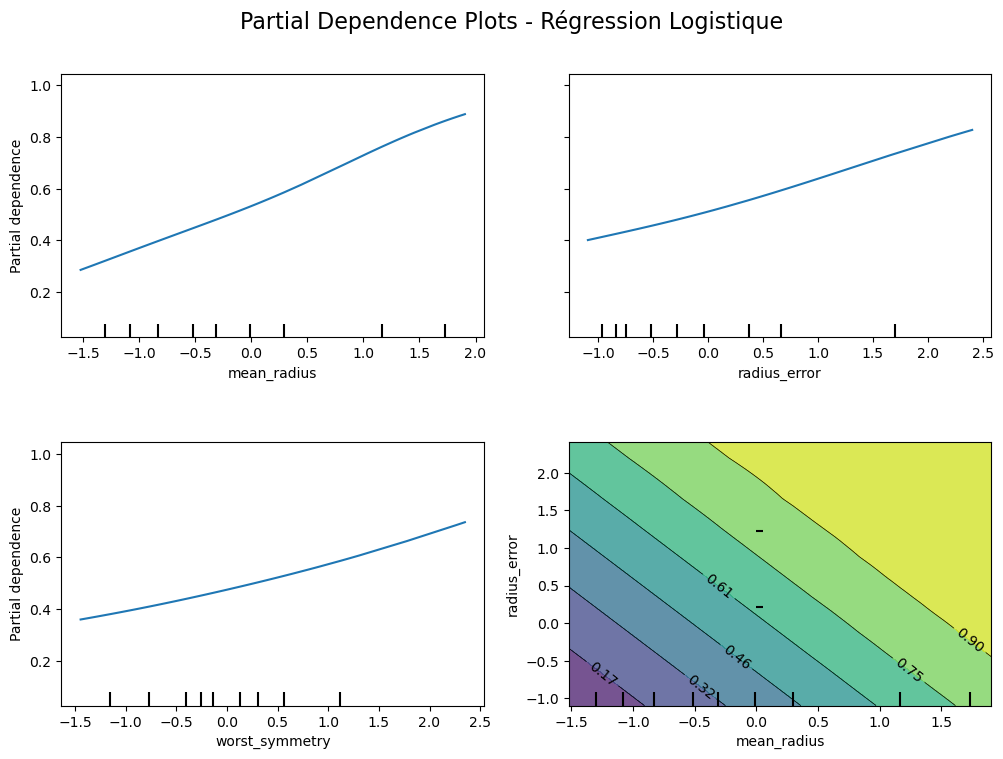

In [54]:
#méthode partial depence plot (PDP)

import warnings
warnings.filterwarnings('ignore')
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

#caractéristiques à analyser
features = ["mean_radius", "radius_error", "worst_symmetry", ('mean_radius', 'radius_error')]

df_interpret = pd.DataFrame(X_test_sc, columns=training_features)

_, ax1 = plt.subplots(figsize=(12, 8))

PartialDependenceDisplay.from_estimator(lgr, 
                                         df_interpret,
                                         features=features,
                                         kind="average",
                                         ax=ax1,
                                         grid_resolution=100,  
                                         n_cols=2 
                                         )

plt.suptitle("Partial Dependence Plots - Régression Logistique", fontsize=16)

plt.subplots_adjust(top=0.9, hspace=0.4)

plt.show()


Les résultats confirment notre interprétation de la régression logistique : lorsque le mean_radius augmente, la probabilité d'une tumeur maligne s'accroît.

#### - Accumulated Local Effect 

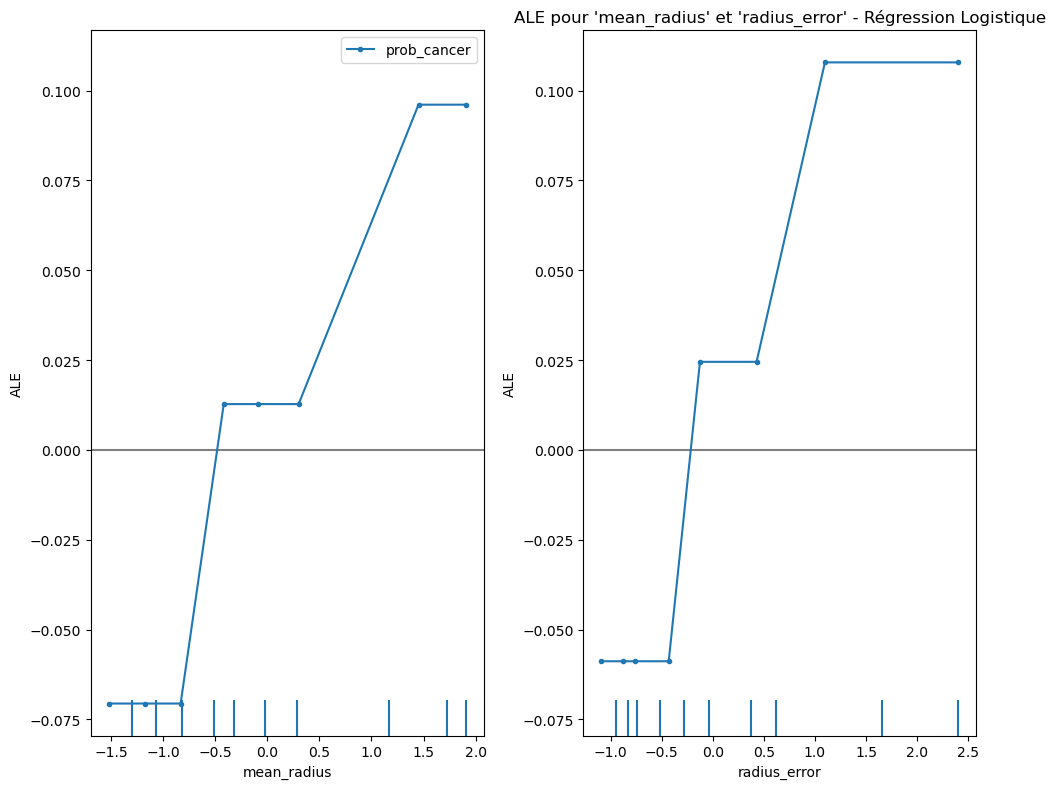

In [56]:
from alibi.explainers import ALE, plot_ale
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

lgr_ale = ALE(lgr.predict, feature_names=training_features, target_names=["prob_cancer"])

lgr_exp = lgr_ale.explain(X_test_sc, min_bin_points=10)

# Visualisation des ALE pour 'mean_radius' et 'radius_error'
_, ax1 = plt.subplots(figsize=(10, 8))
plot_ale(lgr_exp, features=["mean_radius", "radius_error"], ax=ax1, targets=[0])

plt.title("ALE pour 'mean_radius' et 'radius_error' - Régression Logistique")
plt.tight_layout()
plt.show()


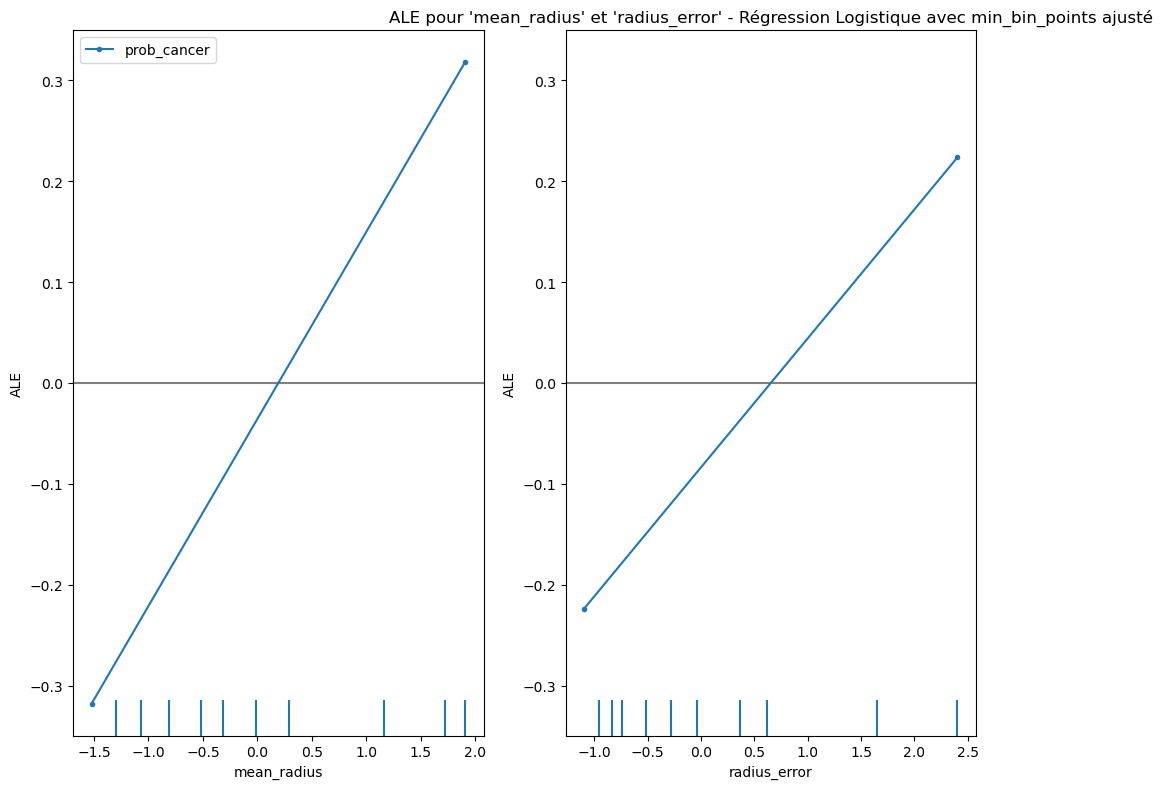

In [58]:
# ajustement de la valeur de min_bin_points dans la fonction explain

lgr_ale = ALE(lgr.predict, feature_names=training_features, target_names=["prob_cancer"])

lgr_exp = lgr_ale.explain(X_test_sc, min_bin_points=50)  

_, ax1 = plt.subplots(figsize=(10, 8))
plot_ale(lgr_exp, features=["mean_radius", "radius_error"], ax=ax1, targets=[0])

plt.title("ALE pour 'mean_radius' et 'radius_error' - Régression Logistique avec min_bin_points ajusté")
plt.tight_layout()
plt.show()


##### - H-Statistic

Nous observons que les effets joints expliquent moins de 10 % de la variabilité expliquée par nos variables. Les variables les plus importantes sont : mean raidus, radius error, worst summetry.

##### - Feature permutation

In [66]:
from sklearn.inspection import permutation_importance

result = permutation_importance(lgr, X_test_sc, y_test,
                                n_repeats=15,  # Nombre de permutations pour chaque feature
                                random_state=0,
                                scoring='accuracy')  # Métrique d'évaluation (précision)

importance_df = pd.DataFrame(result.importances_mean, 
                             index=training_features, 
                             columns=['P-importance'])

importance_df_sorted = importance_df.sort_values(by="P-importance", ascending=False)

importance_df_sorted


,P-importance
mean_radius,0.169412
radius_error,0.086275
worst_symmetry,0.072941
concave_points_error,0.047843
mean_texture,0.036078
worst_smoothness,0.036078
worst_fractal_dimension,0.033725
mean_compactness,0.020392
symmetry_error,0.009412
mean_fractal_dimension,0.007843


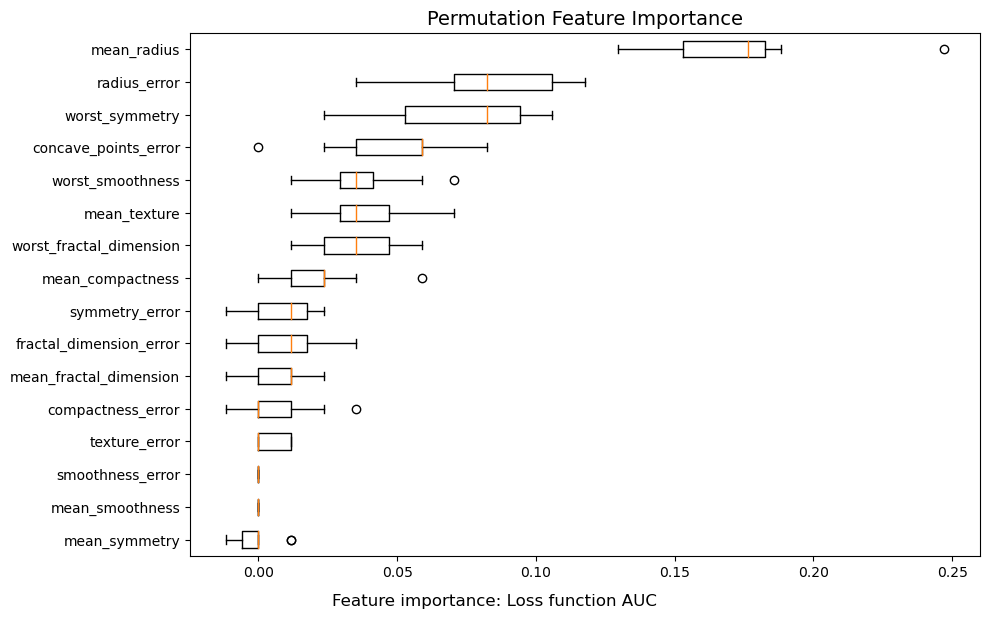

In [67]:
perm_sorted_idx = result.importances_mean.argsort()

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

ax1.boxplot(
    result.importances[perm_sorted_idx].T,  
    vert=False,  
    labels=training_features[perm_sorted_idx]  
)

plt.title('Permutation Feature Importance', fontsize=14)

fig.text(.5, .001, "Feature importance: Loss function AUC", ha='center', va='top', fontsize=12)

fig.tight_layout()

plt.show()


#### 6) Commenter et discuter des limites

L’interprétabilité des modèles devient plus complexe avec l’application de techniques de prétraitement comme la standardisation, qui ajuste les données pour qu’elles aient une moyenne de zéro et une variance de un. Cela améliore l’apprentissage du modèle, mais rend l’interprétation des coefficients plus difficile, car ceux-ci représentent l'impact des variations standardisées des variables, et non plus leurs valeurs réelles. Toutefois, la standardisation permet d’éviter les biais liés aux différences d’échelle entre les variables.

Pour contrer cette complexité, les approches agnostiques au modèle (ou boîtes blanches) permettent d’obtenir une interprétation claire, indépendamment du modèle utilisé. Des techniques comme la régression linéaire ou les méthodes PDP et permutation offrent une vision transparente de l’importance des variables, même dans des modèles complexes. Ces approches rendent l’interprétation plus flexible et compréhensible, assurant que les résultats du modèle restent accessibles, quel que soit le prétraitement ou le modèle sous-jacent. En résumé, les approches agnostiques favorisent l’interprétabilité tout en maintenant la performance du modèle.

#### 7) Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales

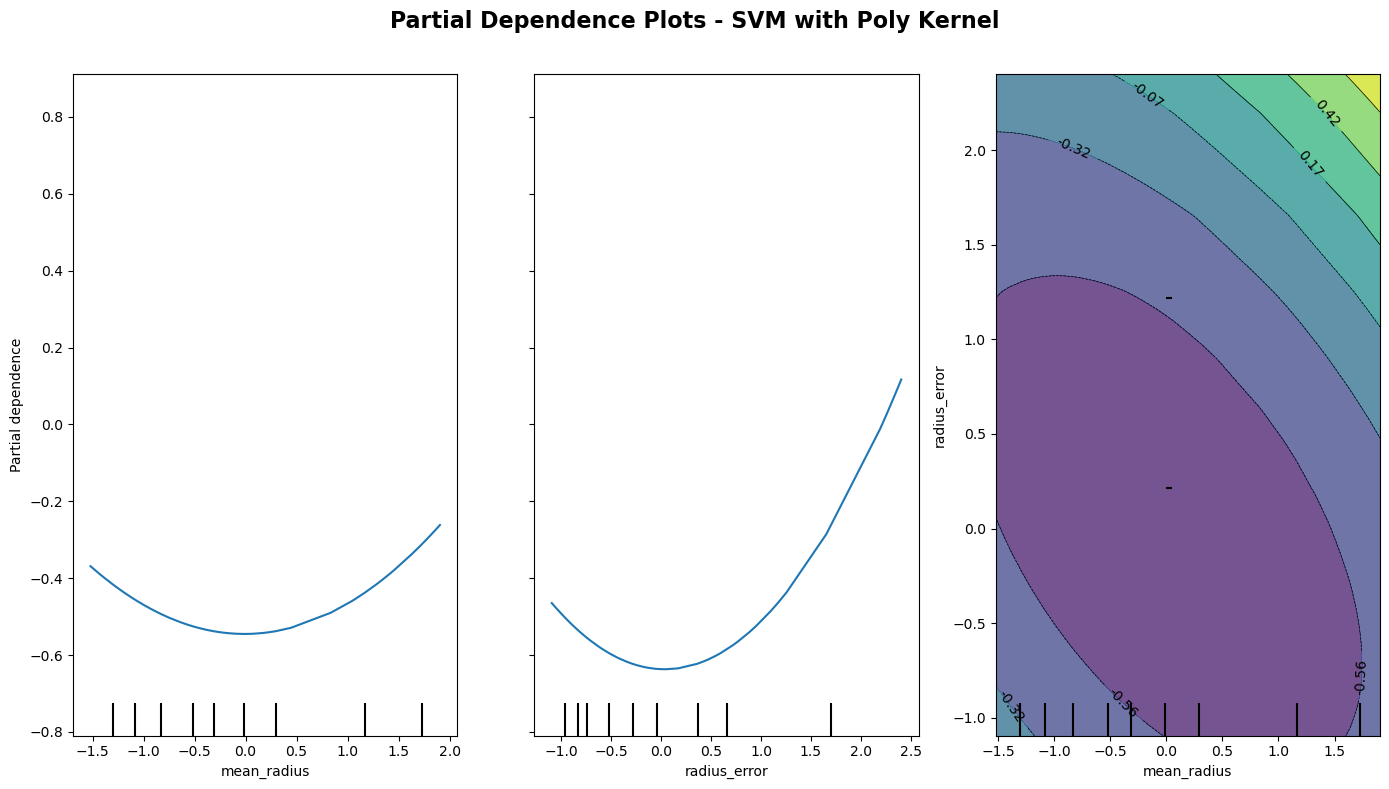

In [68]:
from sklearn.inspection import PartialDependenceDisplay

features = ["mean_radius", "radius_error", ('mean_radius', 'radius_error')]  

_, ax1 = plt.subplots(figsize=(14, 8))

PartialDependenceDisplay.from_estimator(
    best_model,  
    df_interpret, 
    features=features,
    kind="average",  
    ax=ax1,
    grid_resolution=100,  
    n_cols=3 
)

plt.suptitle("Partial Dependence Plots - SVM with Poly Kernel", fontsize=16, fontweight='bold')

plt.tight_layout()

plt.subplots_adjust(top=0.9)  

plt.show()


array([[<Axes: xlabel='mean_radius', ylabel='ALE'>,
        <Axes: xlabel='mean_texture', ylabel='ALE'>]], dtype=object)

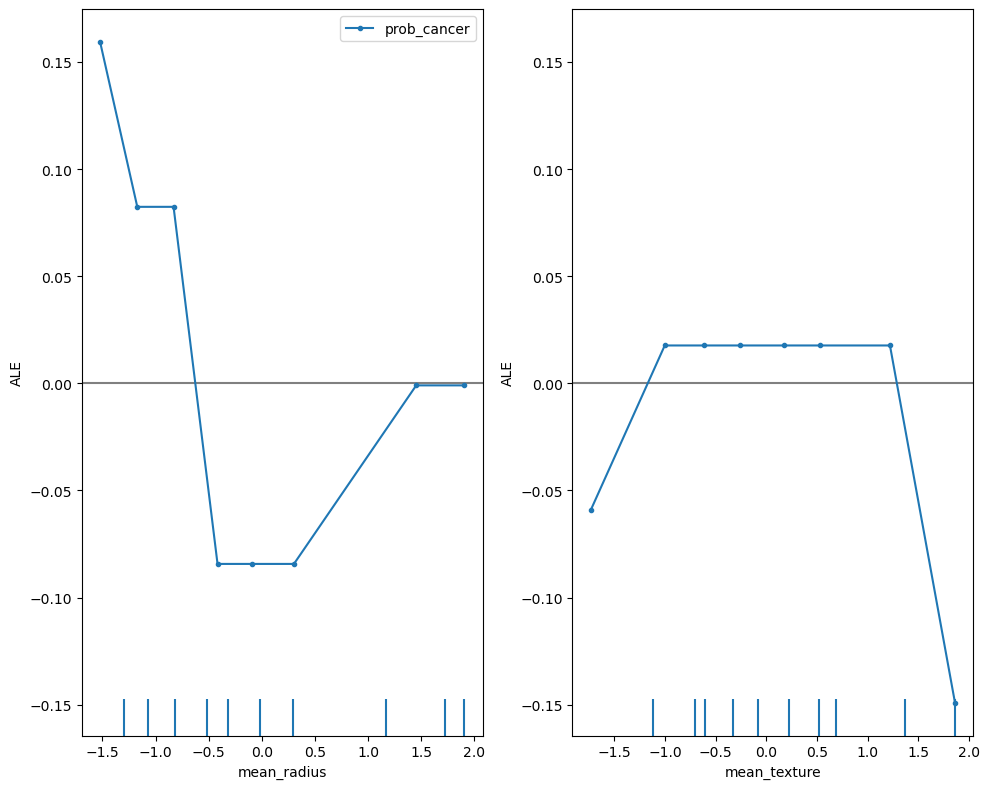

In [69]:
svm_ale = ALE(best_model.predict, feature_names=training_features, target_names=["prob_cancer"])
svm_exp = svm_ale.explain(X_test_sc, min_bin_points=10)

_, ax1 = plt.subplots(figsize = (10,8))
plot_ale(svm_exp, features=["mean_radius","mean_texture"], ax= ax1, targets=[0])

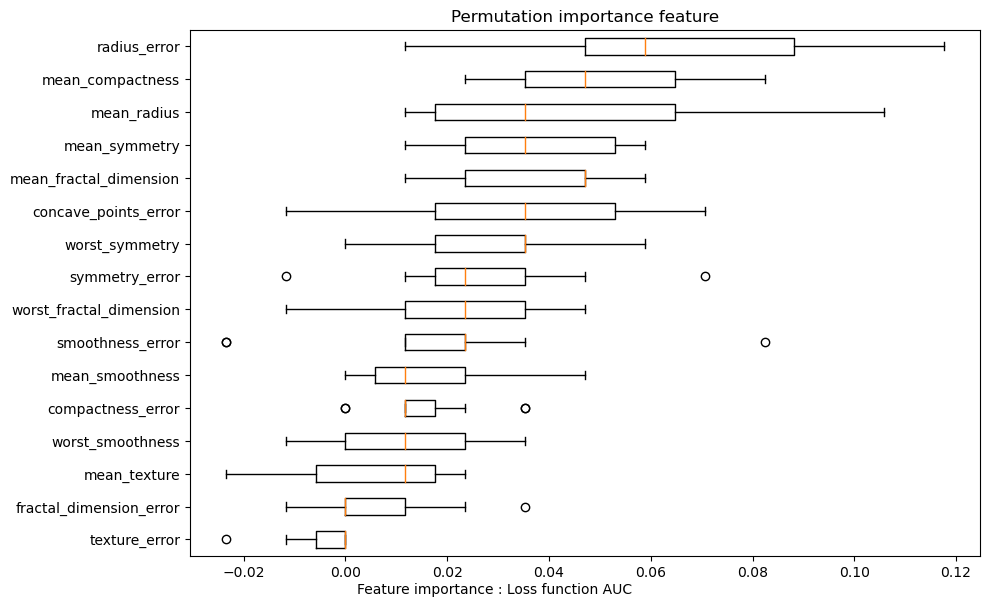

In [73]:
result = permutation_importance(best_model, X_test_sc, y_test,
                           n_repeats=15,
                           random_state=0,
                           scoring="accuracy"
                           )
perm_sorted_idx = result.importances_mean.argsort()

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
ax1.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=training_features[perm_sorted_idx]
)
plt.title('Permutation importance feature')
fig.text(.5, .001, "Feature importance : Loss function AUC", ha='center')

fig.tight_layout()
plt.show()

La variable radius_error joue un rôle crucial dans le modèle, et son absence a un impact significatif sur la performance du modèle. En retirant cette variable, nous observons une diminution moyenne d'environ 10% de la valeur de l'AUC, ce qui indique qu'elle contribue de manière substantielle à la capacité du modèle à différencier entre les tumeurs malignes et bénignes. De plus, la variable mean_compactness présente également un impact notable : son exclusion entraîne une perte d'information importante, réduisant ainsi la précision du modèle dans la classification. Ces deux variables, en étant présentes, améliorent les prédictions du modèle, et leur absence diminue la capacité de celui-ci à réaliser des discriminations correctes.